In [1]:
import numpy as np
import matplotlib.pyplot as plt
from bandit import Bandits_final
from collections import deque

In [2]:
np.random.seed(0)

In [3]:
def decaying_epsilon_greedy(mab, num_steps=5000, epsilon_start=1.0, epsilon_decay=0.999, epsilon_min=0.001, alpha=-1):
    k = mab.k  # number of actions
    Q = np.zeros(k)  # estimated values for each action
    N = np.zeros(k)  # number of times each action was taken

    rewards = []
    regrets = []
    optimal_action_counts = np.zeros(num_steps)

    epsilon = epsilon_start

    for t in range(num_steps):
        if np.random.rand() < epsilon:
            action = np.random.randint(0, k)  # exploration
        else:
            action = np.argmax(Q)  # exploitation

        _, reward, _, _, _ = mab.step(action)

        rewards.append(reward)

        # check if the action was optimal
        optimal_action = mab.get_optimal_action()
        if action == optimal_action:
            optimal_action_counts[t] = 1  # mark as optimal

        regret = mab.means[optimal_action] - reward
        regrets.append(regret)

        N[action] += 1
        # if alpha is -1, the step size is dynamic, averaging the rewards;
        # with constant alpha, each reward has equal weight, with increased response to recent rewards.
        step_size = 1 / N[action] if alpha == -1 else alpha
        Q[action] += step_size * (reward - Q[action])

        epsilon = max(epsilon_min, epsilon_decay * epsilon)

    percent_optimal_actions = np.cumsum(optimal_action_counts) / np.arange(1, num_steps + 1)

    return {
        "rewards": rewards,
        "percent_optimal_actions": percent_optimal_actions,
        "regrets": regrets,
    }

In [4]:
def d_ucb(mab, num_steps=5000, c=1, gamma=0.9):
    k = mab.k
    Q = np.zeros(k)
    N = np.zeros(k)  # number of times each arm has been pulled
    total_counts = np.zeros(k)  # scaled-down count of each arm with discounting

    rewards = []
    regrets = []
    optimal_action_counts = np.zeros(num_steps)

    for t in range(num_steps):
        if t < k:
            action = t
        else:
            confidence_bound = c * np.sqrt(2 * np.log(t) / total_counts)
            action = np.argmax(Q + confidence_bound)

        _, reward, _, _, _ = mab.step(action)

        rewards.append(reward)

        # check if the action was optimal
        optimal_action = mab.get_optimal_action()
        if action == optimal_action:
            optimal_action_counts[t] = 1  # mark as optimal

        regret = mab.means[optimal_action] - reward
        regrets.append(regret)

        N[action] += 1
        # with gamma = 1, D-UCB boils down to the standard UCB algorithm
        total_counts[action] = gamma * total_counts[action] + 1
        Q[action] = gamma * Q[action] + (reward - Q[action]) / N[action]

    percent_optimal_actions = np.cumsum(optimal_action_counts) / np.arange(1, num_steps + 1)

    return {
        "rewards": rewards,
        "percent_optimal_actions": percent_optimal_actions,
        "regrets": regrets,
    }

In [5]:
def sw_ucb(mab, num_steps=5000, c=1, window_size=100):
    k = mab.k
    actions_history = []  # history of actions taken
    rewards_history = []  # history of rewards received

    rewards = []
    regrets = []
    optimal_action_counts = np.zeros(num_steps)

    for t in range(num_steps):
        if t < k:
            action = t  # initially pull each arm once
        else:
            # calculate the upper confidence bounds for each arm using the sliding window
            recent_actions = actions_history[-window_size:]
            recent_rewards = rewards_history[-window_size:]

            total_counts = np.array([recent_actions.count(i) for i in range(k)]) + 1e-10
            total_rewards = np.array(
                [sum(recent_rewards[j] for j in range(len(recent_rewards)) if recent_actions[j] == i) for i in
                 range(k)])

            averages = total_rewards / total_counts

            confidence_bounds = averages + c * np.sqrt(np.log(min(t, window_size)) / total_counts)
            action = np.argmax(confidence_bounds)  # select the arm with the highest UCB

        _, reward, _, _, _ = mab.step(action)
        rewards.append(reward)
        actions_history.append(action)
        rewards_history.append(reward)

        # check if the action was optimal
        optimal_action = mab.get_optimal_action()
        if action == optimal_action:
            optimal_action_counts[t] = 1  # mark as optimal

        regret = mab.means[optimal_action] - reward
        regrets.append(regret)

    percent_optimal_actions = np.cumsum(optimal_action_counts) / np.arange(1, num_steps + 1)

    return {
        "rewards": rewards,
        "percent_optimal_actions": percent_optimal_actions,
        "regrets": regrets,
    }

In [6]:
def run_bandit_simulation(strategy_func, num_runs=500, num_steps=5000, **strategy_kwargs):
    avg_reward = np.zeros(num_steps)
    avg_optimal_actions = np.zeros(num_steps)
    avg_regret = np.zeros(num_steps)

    for run in range(num_runs):
        mab = Bandits_final()
        results = strategy_func(mab, num_steps=num_steps, **strategy_kwargs)
        avg_reward += results["rewards"]
        avg_optimal_actions += results["percent_optimal_actions"]
        avg_regret += results["regrets"]

    avg_reward /= num_runs
    avg_optimal_actions /= num_runs
    avg_regret /= num_runs

    return {
        "rewards": avg_reward,
        "percent_optimal_actions": avg_optimal_actions,
        "regrets": avg_regret,
    }

In [7]:
step_sizes = [-1, 0.01, 0.1, 0.25]
dec_eps_greedy_simulation_results = {
    step_size: run_bandit_simulation(strategy_func=decaying_epsilon_greedy, alpha=step_size)
    for step_size in step_sizes}

In [8]:
gamma_values = [1, 0.9, 0.95, 0.995]
d_ucb_simulation_results = {gamma: run_bandit_simulation(strategy_func=d_ucb, gamma=gamma) for gamma in gamma_values}

In [9]:
window_sizes = [50, 100, 200, 500]
sliding_window_ucb_simulation_results = {
    window_size: run_bandit_simulation(strategy_func=sw_ucb, window_size=window_size) for
    window_size in window_sizes}

In [10]:
def plot_simulation_results(simulation_results, labels, title):
    cmap = plt.get_cmap("Paired")
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    for i, results in enumerate(simulation_results):
        axs[0].plot(results["rewards"], label=labels[i], color=cmap(i / len(simulation_results)))
        axs[1].plot(results["percent_optimal_actions"], label=labels[i], color=cmap(i / len(simulation_results)))
        axs[2].plot(np.cumsum(results["regrets"]), label=labels[i], color=cmap(i / len(simulation_results)))

    axs[0].set_title("Average Reward")
    axs[0].set_ylabel("Average Reward")
    axs[1].set_title("Percentage of Optimal Actions")
    axs[1].set_ylabel("Optimal Action %")
    axs[2].set_title("Cumulative Regret")
    axs[2].set_ylabel("Cumulative Regret")

    for i in range(3):
        axs[i].set_xlabel("Steps")
        axs[i].grid(color='silver', linestyle="--", linewidth=0.5)

    handles, labels = axs[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.01), ncol=len(labels))
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

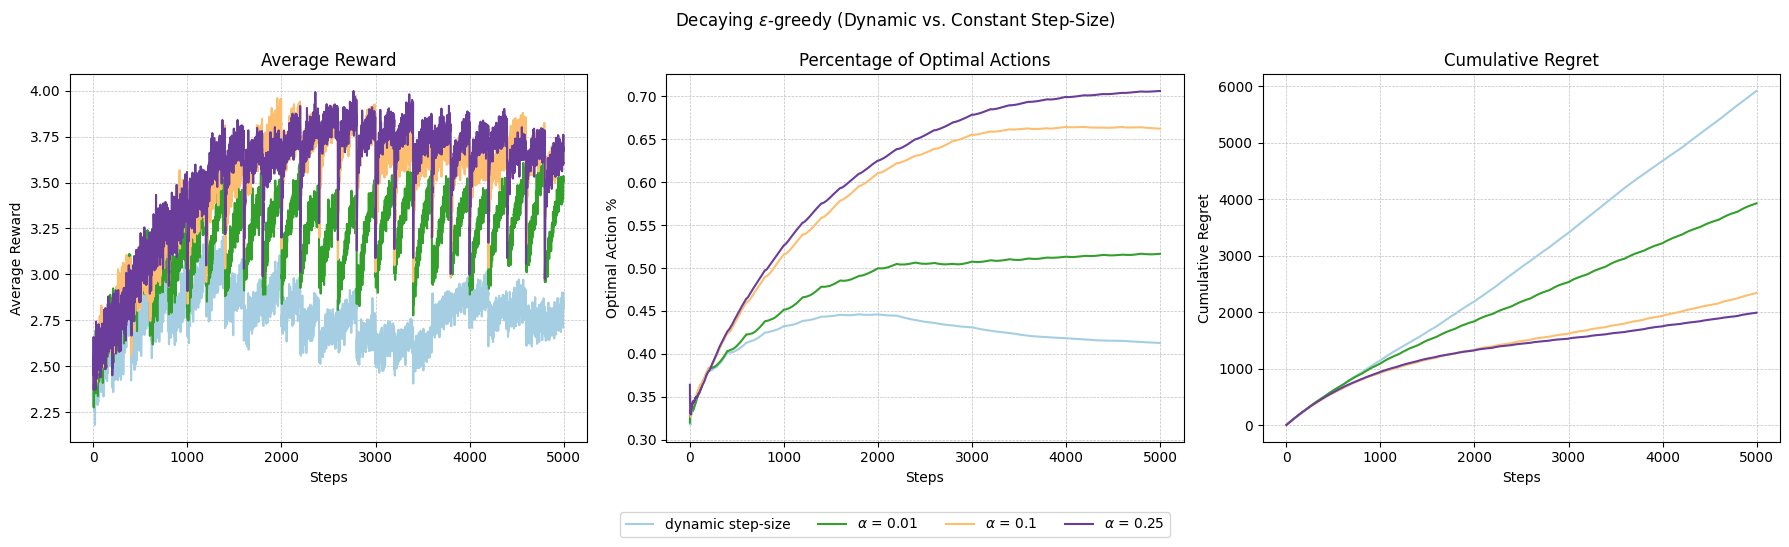

In [11]:
dec_eps_greedy_simulation_labels = ["dynamic step-size" if alpha == -1 else f"$\\alpha$ = {alpha}" for alpha in
                                    step_sizes]
plot_simulation_results(dec_eps_greedy_simulation_results.values(), dec_eps_greedy_simulation_labels,
                        title="Decaying $\epsilon$-greedy (Dynamic vs. Constant Step-Size)")

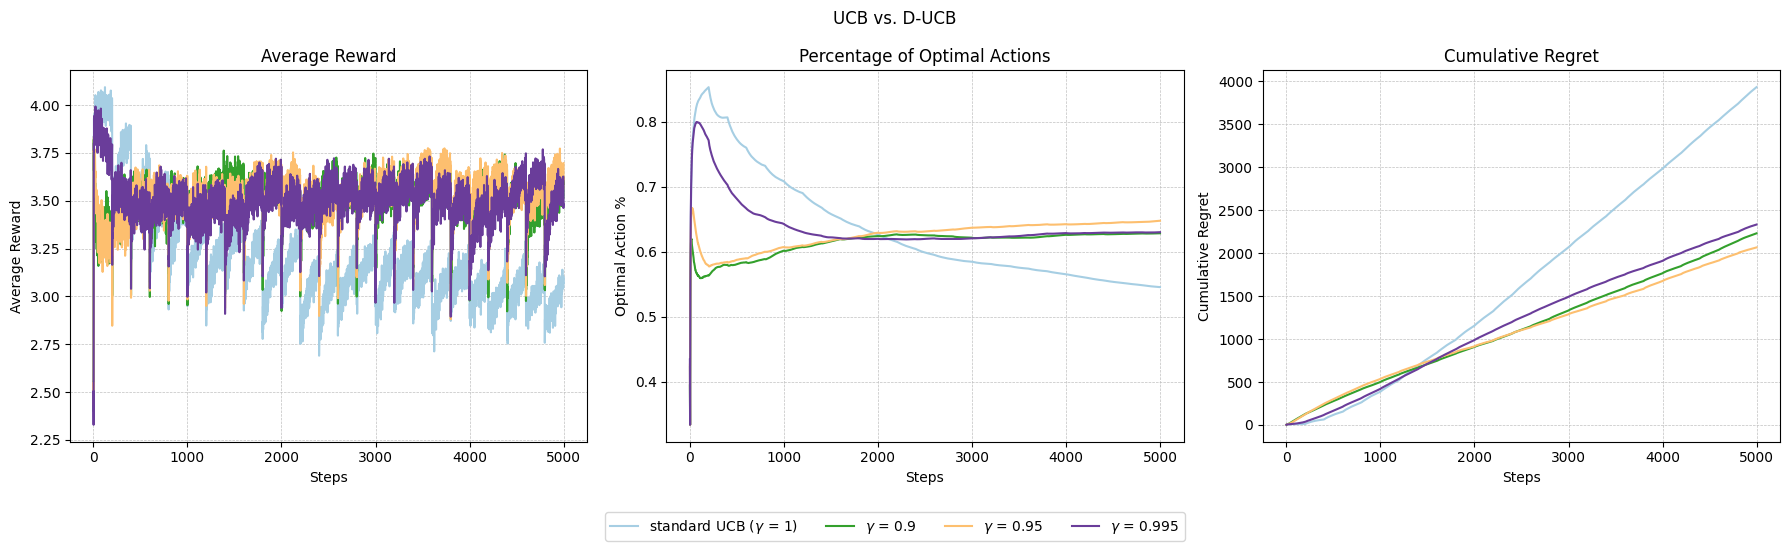

In [12]:
d_ucb_simulation_labels = ["standard UCB ($\gamma$ = 1)" if gamma == 1 else f"$\gamma$ = {gamma}"
                           for gamma in gamma_values]
plot_simulation_results(d_ucb_simulation_results.values(), d_ucb_simulation_labels, title="UCB vs. D-UCB")

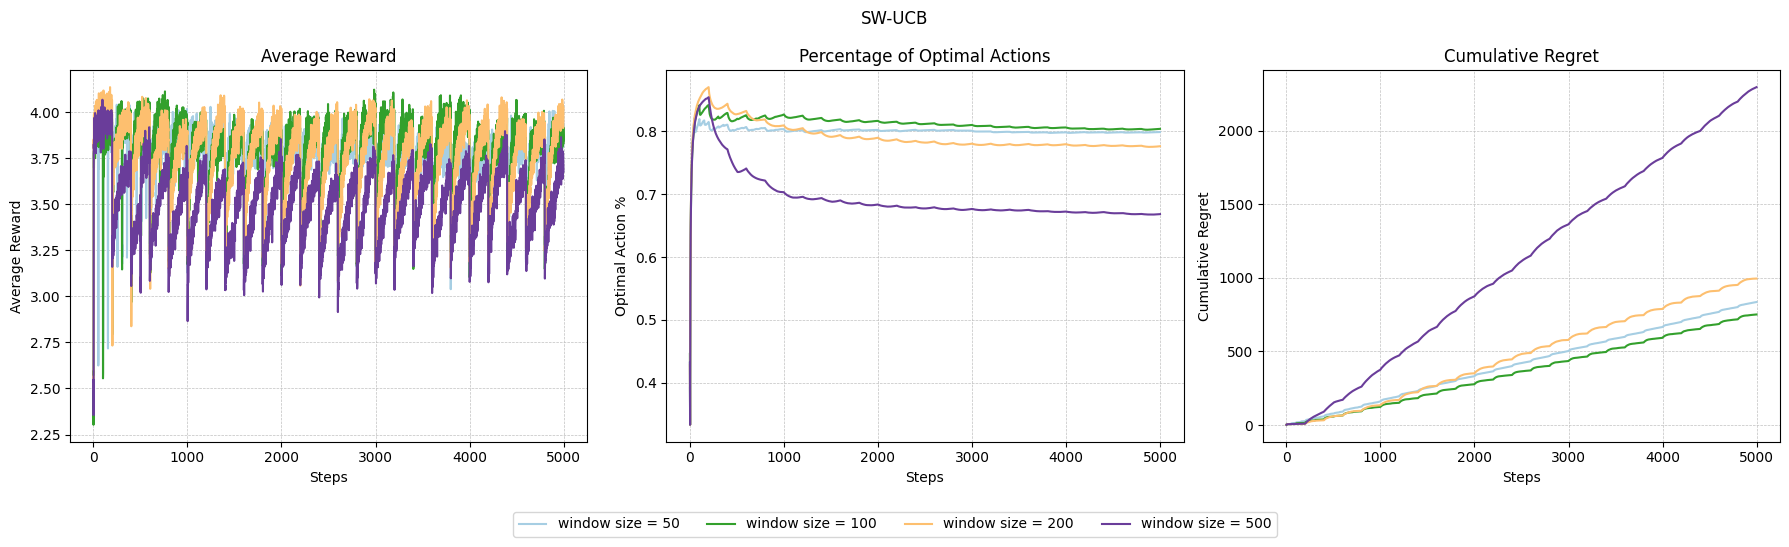

In [13]:
sliding_window_ucb_simulation_labels = [f"window size = {window_size}" for window_size in window_sizes]
plot_simulation_results(sliding_window_ucb_simulation_results.values(), sliding_window_ucb_simulation_labels,
                        title="SW-UCB")

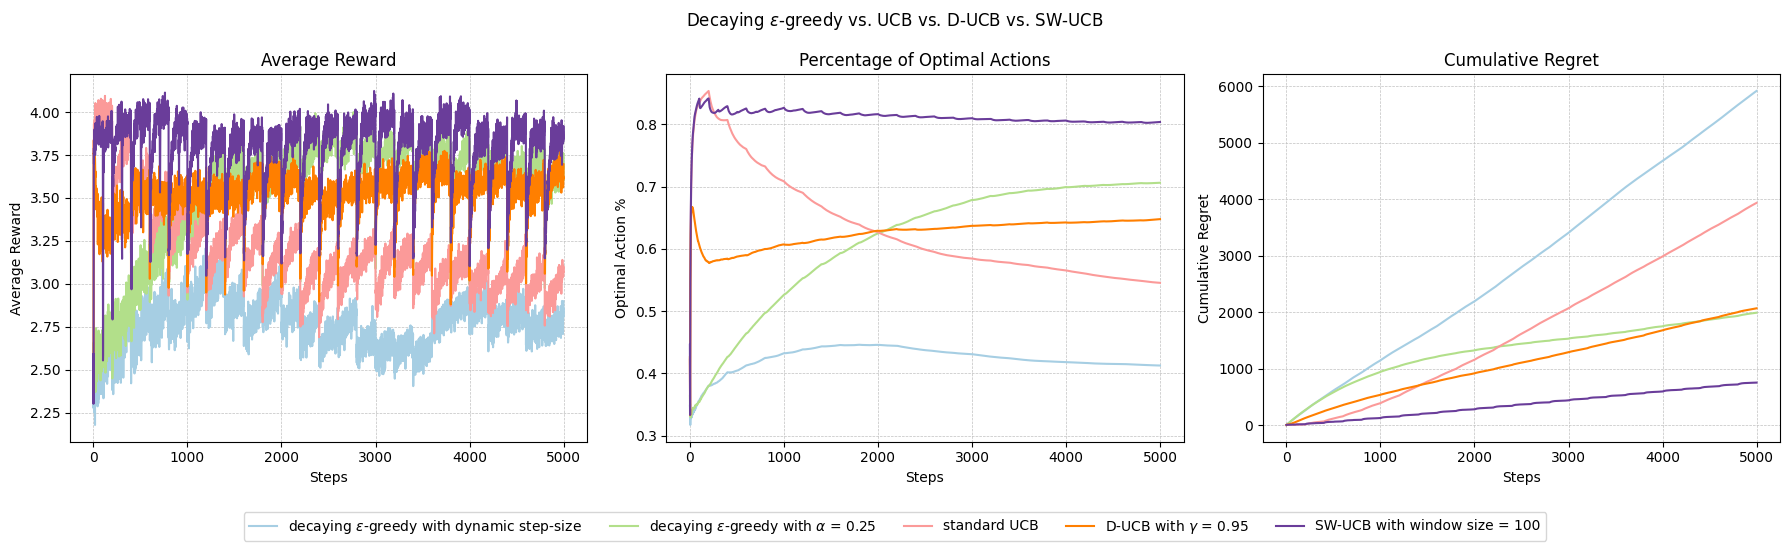

In [14]:
combined_simulation_results = [dec_eps_greedy_simulation_results[-1],
                               dec_eps_greedy_simulation_results[0.25],
                               d_ucb_simulation_results[1],
                               d_ucb_simulation_results[0.95],
                               sliding_window_ucb_simulation_results[100]]
combined_simulation_labels = ["decaying $\epsilon$-greedy with dynamic step-size",
                              "decaying $\epsilon$-greedy with $\\alpha$ = 0.25",
                              "standard UCB",
                              "D-UCB with $\gamma$ = 0.95",
                              "SW-UCB with window size = 100"]
plot_simulation_results(combined_simulation_results, combined_simulation_labels,
                        title="Decaying $\epsilon$-greedy vs. UCB vs. D-UCB vs. SW-UCB")